<img src="The_LSTM.png" width="500" height="300" align="right"/>

# LSTM with Convolutional Layer

Author: Christoph Güttner


**Abstract**  
We build a LSTM Network with 21.313 trainable parameters   
to predict a SARIMA Process(1,1,1)(3,1,2)_30.  

The LSTM has one convolution layer with filter size 64 and two  
dense layers that map each input to a scalar (Regression Analysis).  
For feature extraction the training and test data is brought  
into pieces of size 10 (X) to predict the respectivly 11th value(y).  
  
**Result:** LSTM Networks are a adequate tool to analyse stochastic  
processes with a short term memory.

## Table of Contents
* [Loading and Preprocessing](#Loading_and_Preprocessing)
    * [Imports](#Imports)
    * [Functions](#Functions)

* [Time Series Data](#Time_Series_Data)
    * [Normalize](#Normalize)
    * [Visualise Data](#Visualise_Data)
* [Data Preprocessing](#Time_Series_Data)
    * [Normalize](#Normalize)
    * [Feature Extraction](#Feature_Extraction)
* [LSTM Model Building](#Model_Selection)
    * [LSTM Model](#LSTM_Modell)
    * [Model Training](#Model_Training)
* [Prediction](#Prediction)
    * [Inverse Transformation](#Inverse_Transformation)
    * [Visualise Prediction](#Visualise_Predictions)
* [Evaluation](#Model_Selection)
    * [Train Score: MSE](#Train_Score)
    * [Train Score: MSE](#Train_Score)

## Imports

In [47]:
import math
import numpy as np

from fbm import MBM

import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Flatten
from keras.layers import Dense
from keras.layers import ConvLSTM2D
from sklearn.metrics import mean_squared_error



In [48]:

def generate_Seasonal_ARMA(ts, p, q, m, a, b, c, sigma):
    
    epsilon = np.float64(np.random.normal(0,sigma, len(ts)))

    for t in range(p+m, len(ts)):
        sum = 0.0
        for i in range(1,p+1):
            sum += a[i-1] * ts[(t-(i*m))]
        for j in range(1,q+1):
            epsilon[t-(j*m)] = np.float64(np.random.normal(0.0, sigma))
            sum += b[j-1] * epsilon[(t-(j*m))]
        epsilon[t] = np.float64(np.random.normal(0.0, sigma))
        ts[t] = np.float64(c) + np.float64(epsilon[t]) + sum
    return np.array(ts)
    
def generate_ARMA(ts, p, q, a, b, c,m, sigma):

    epsilon = np.float64(np.zeros(len(ts)))

    for t in range(p, len(ts)):
        sum = 0.0
        for i in range(1,p+1):
            sum += a[i-1] * ts[t-i]
        for j in range(1,q+1):
            epsilon[t-j] = np.float64(np.random.normal(0.0, sigma))
            sum += b[j-1] * epsilon[t-j]
        epsilon[t] = np.float64(np.random.normal(0.0, sigma))
        ts[t] = np.float64(c) + np.float64(epsilon[t]) + sum
    return np.array(ts[m:])

def get_seasonal_integration(ts, m):
    rv = []
    for i in range(m,len(ts)):
        # ts[i]= (ts[i-1] + ts[i-1-m])/2
        rv.append(ts[i-1] + ts[i-1-m])
    si = np.array(rv)
    return si

def get_integration_order(ts, n_order):
    for i in range(n_order):
        ts = np.cumsum(np.array(ts))
    return np.array(ts)


def get_data_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)

## Time Series Data

In [49]:
np.random.seed(42)
# Example Hurst function with respect to time.
n_samples=1036
sigma = 2.0
y = np.float64(np.random.normal(0,sigma, n_samples))
np.random.seed(1)
#parameter for SARIMA
p1=1
q1=1
a1=[0.66]
b1=[0.06]
#parameter for ARIMA
p=3
q=2
a=[0.45, 0.46, 0.03]
b=[0.02, 0.07]

c=0.0

n_order=1
m=30


ts1 = generate_ARMA(y, p1, q1, a1, b1, c, m,sigma)
ts1 = get_integration_order(ts1, n_order)

ts2 = generate_Seasonal_ARMA(y, p, q,m, a, b, c, sigma)
ts2 = get_seasonal_integration(ts2, m)

ts = ts1 + ts2

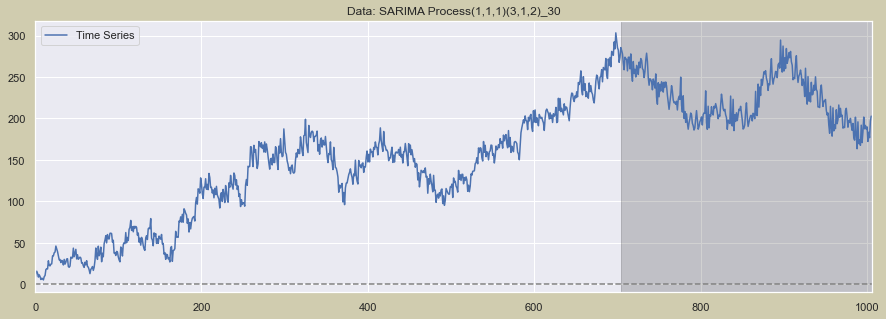

In [50]:
plt.figure(facecolor='#D0CCAF', figsize=(15,5))
plt.plot( ts,label='Time Series')
plt.title('Data: SARIMA Process(1,1,1)(3,1,2)_30')
plt.axhline(0, linestyle='--', color='grey')
plt.axvspan(len(ts) *0.7,len(ts), color='k', alpha=0.2)
plt.xlim(0,len(ts))
plt.legend()

## Data Prepocessing

### Normalise

In [51]:

normal = MinMaxScaler(feature_range=(0, 1))
dataset = normal.fit_transform(ts.reshape(-1, 1))

### Train Test Split

In [52]:

train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

len(dataset), len(train), len(test)

(1006, 704, 302)

### Feature Extraction

In [53]:
seq_size = 10  # Number of time steps to look back 

trainX, trainY = get_data_sequences(train, seq_size)
testX, testY = get_data_sequences(test, seq_size)

In [54]:
trainX = trainX.reshape((trainX.shape[0], 1, 1, 1, seq_size))
testX = testX.reshape((testX.shape[0], 1, 1, 1, seq_size))

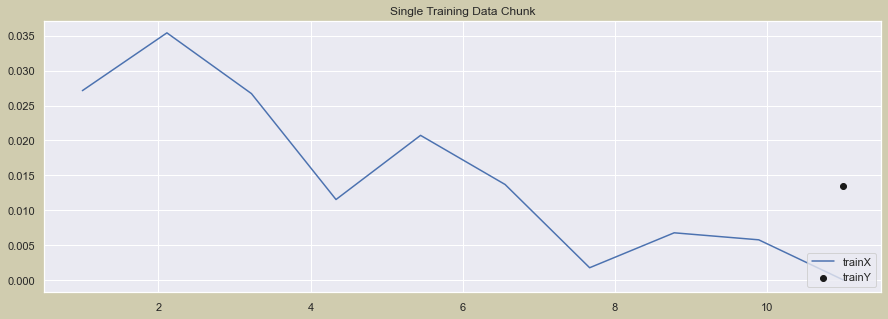

In [55]:
plt.figure(facecolor='#D0CCAF', figsize=(15,5))
plt.title('Single Training Data Chunk')
plt.plot(np.linspace(1, 11,10),trainX[1][0][0][0], label='trainX')
plt.scatter(11, trainY[1], color='k', label='trainY')
plt.legend(loc='lower right')

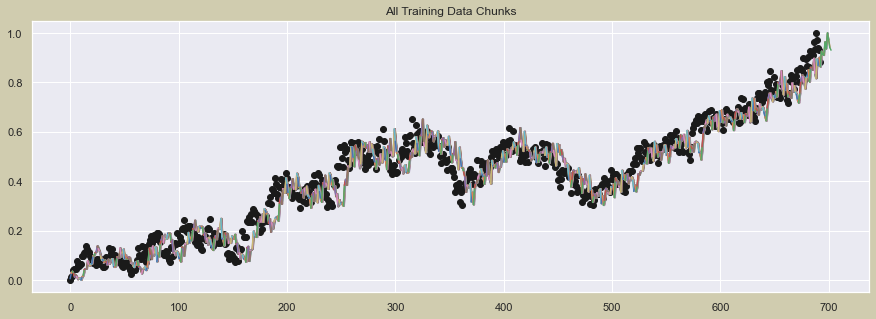

In [56]:
plt.figure(facecolor='#D0CCAF', figsize=(15,5))
plt.title('All Training Data Chunks')
for i in range(trainX.shape[0]):
    plt.plot(np.linspace(i, i+10,10),trainX[i][0][0][0])
    plt.scatter([i],trainY[i], color='k')

## Building the LSTM Model

In [57]:

model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,1), activation='relu', input_shape=(1, 1, 1, seq_size)))
model.add(Flatten())
model.add(Dense(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
#print('Train...')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, 1, 1, 64)          19200     
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 21,313
Trainable params: 21,313
Non-trainable params: 0
_________________________________________________________________


In [58]:
model.fit(trainX, trainY, validation_data=(testX, testY),
          verbose=2, epochs=25)

Epoch 1/25
22/22 - 1s - loss: 0.0856 - val_loss: 0.0031
Epoch 2/25
22/22 - 0s - loss: 0.0095 - val_loss: 0.0084
Epoch 3/25
22/22 - 0s - loss: 0.0045 - val_loss: 0.0018
Epoch 4/25
22/22 - 0s - loss: 0.0022 - val_loss: 0.0020
Epoch 5/25
22/22 - 0s - loss: 0.0016 - val_loss: 0.0026
Epoch 6/25
22/22 - 0s - loss: 0.0014 - val_loss: 0.0028
Epoch 7/25
22/22 - 0s - loss: 0.0014 - val_loss: 0.0022
Epoch 8/25
22/22 - 0s - loss: 0.0013 - val_loss: 0.0024
Epoch 9/25
22/22 - 0s - loss: 0.0013 - val_loss: 0.0020
Epoch 10/25
22/22 - 0s - loss: 0.0013 - val_loss: 0.0023
Epoch 11/25
22/22 - 0s - loss: 0.0012 - val_loss: 0.0024
Epoch 12/25
22/22 - 0s - loss: 0.0012 - val_loss: 0.0020
Epoch 13/25
22/22 - 0s - loss: 0.0012 - val_loss: 0.0020
Epoch 14/25
22/22 - 0s - loss: 0.0012 - val_loss: 0.0019
Epoch 15/25
22/22 - 0s - loss: 0.0012 - val_loss: 0.0020
Epoch 16/25
22/22 - 0s - loss: 0.0011 - val_loss: 0.0021
Epoch 17/25
22/22 - 0s - loss: 0.0011 - val_loss: 0.0021
Epoch 18/25
22/22 - 0s - loss: 0.0011 - 

## Get Predictions

In [59]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

### Rescale Data

In [60]:
#Since we used minmaxscaler we can now use scaler.inverse_transform
#to invert the transformation.

dataset      = normal.inverse_transform(dataset)

trainPredict = normal.inverse_transform(trainPredict)
testPredict  = normal.inverse_transform(testPredict)

trainY = normal.inverse_transform([trainY])
testY = normal.inverse_transform([testY])



### Shift Data back to Sequence

In [61]:
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan

trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict

### Visualise_Predictions

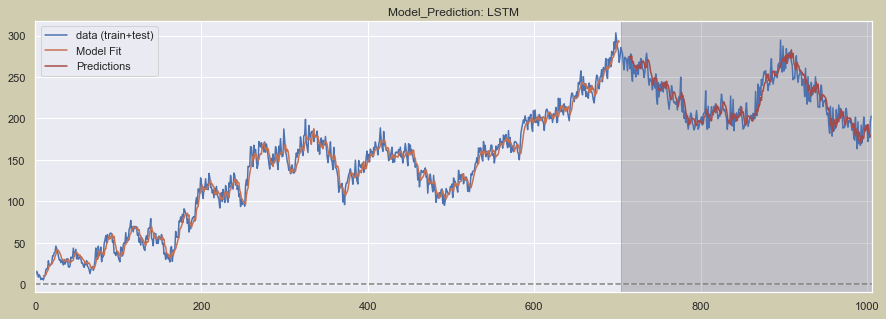

In [62]:

plt.figure(facecolor='#D0CCAF', figsize=(15,5))
plt.plot(dataset, label='data (train+test)')
plt.plot(trainPredictPlot, color='#C67052', label='Model Fit')
plt.plot(testPredictPlot, color='#A54A48', label='Predictions')
plt.title('Model_Prediction: LSTM')
plt.axhline(0, linestyle='--', color='grey')
plt.axvspan(len(ts) *0.7,len(ts), color='k', alpha=0.2)
plt.xlim(0,len(ts))
plt.legend()
plt.show()

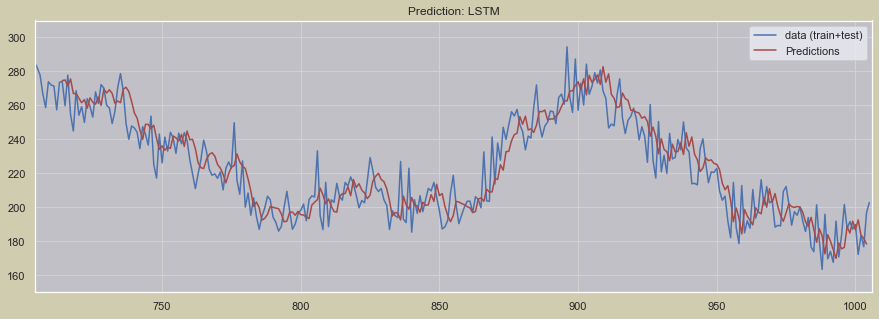

In [68]:
plt.figure(facecolor='#D0CCAF', figsize=(15,5))
plt.plot(dataset, label='data (train+test)')
plt.plot(testPredictPlot, color='#A54A48', label='Predictions')
plt.title('Prediction: LSTM')
plt.axhline(0, linestyle='--', color='grey')
plt.axvspan(len(ts) *0.7,len(ts), color='k', alpha=0.2)
plt.xlim(len(ts) *0.7,len(ts))
plt.ylim(150,310)
plt.legend()
plt.show()

## Evaluation (Mean Squared Error)

### TrainScore

In [63]:
# calculate root mean squared error
trainScore = mean_squared_error(trainY[0], trainPredict[:,0])
print('Train Score: The MSE is %.2f.' % (trainScore))

Train Score: The MSE is 87.61.


### TestScore

In [64]:
testScore = mean_squared_error(testY[0], testPredict[:,0])
print('Test Score: The MSE is %.2f.' % (testScore))

Test Score: The MSE is 165.71.
